In [27]:
import numpy
import random
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from PIL import Image
import pandas
from sklearn.linear_model import LinearRegression, LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
import seaborn
import scipy
from scipy import stats
from scipy.stats import poisson, ttest_ind
from scipy import linalg
import xarray as xr
import netCDF4
import cftime
import readline
import os

In [2]:
# Open File
def Create_DF(File):
    Data = open(File, 'r')
    Rows = []
#
# Organize Data
    for Line in Data:
        Rows.append(Line.strip())
#print (Rows)
#
# Organize Data Into Dictionary Containing Arrays
    Storm_Code = []
    Storm_List = []
    for i in range(len(Rows)):
        if Rows[i][0:5] == 'start':
            Code = Rows[i][41:45]
            Storm_List.append(Code)
        else:
            Storm_Code.append(Code)
    Array = numpy.zeros((13, len(Rows)-len(Storm_List)))
    Time = []
    k = -1
    for i in range(len(Rows)):
        if Rows[i][0:5] == 'start':
            k += 1
        else:
            Array[0][i-k-1] = float(Rows[i][0:6])
            Array[1][i-k-1] = float(Rows[i][9:14])
            Array[2][i-k-1] = float(Rows[i][17:24])
            Array[3][i-k-1] = float(Rows[i][27:31])
            Array[4][i-k-1] = float(Rows[i][34:41])
            Array[5][i-k-1] = float(Rows[i][44:51])
            Array[6][i-k-1] = float(Rows[i][54:61])
            Array[7][i-k-1] = float(Rows[i][64:71])
            Array[8][i-k-1] = float(Rows[i][74:81])
            Time.append(datetime.datetime(year=int(Rows[i][84:88]), month=int(Rows[i][90:92]), \
            day=int(Rows[i][94:96]), hour=int(Rows[i][98:100])))
#        Array[9][i-k-1] = int(Rows[i][84:88])
#        Array[10][i-k-1] = int(Rows[i][90:92])
#        Array[11][i-k-1] = int(Rows[i][94:96])
#        Array[12][i-k-1] = int(Rows[i][98:100])
#        print (Rows[i])
#        print (float(Rows[i][9:14]))
#        print (Rows[i][17])
#print (Array)
#
# Create DataFrame to Store Data
    DF = pandas.DataFrame({"Code": Storm_Code, "Lon": Array[0], "Lat": Array[1], "SLP(hPa)": Array[2], \
    "Winds(m/s)": Array[3], "Dist(m)": Array[4], "Angle": Array[5], "B": Array[6], "VLT": Array[7], "VUT": Array[8], \
    "Time(Z)": Time})
#"Year": Array[9], "Month": Array[10], "Day": Array[11], "Hour(Z)": Array[12]})
    return (DF, Storm_List)
DF_Init, Storm_List = Create_DF('/glade/u/home/whimkao/ExtraTrack/ExTraTrack/et-tracker/text_files/traj_et_erai_avg')
DF_Init

,Code,Lon,Lat,SLP(hPa),Winds(m/s),Dist(m),Angle,B,VLT,VUT,Time(Z)
0,9901,302.50,18.00,1003.91,19.2,-999.00,-999.00,-999.00,-999.00,-999.00,1999-09-10 00:00:00
1,9901,302.00,18.50,1002.09,23.5,76.68,316.56,-6.90,80.45,80.42,1999-09-10 06:00:00
2,9901,301.00,19.50,1002.61,21.0,153.03,316.77,-6.42,81.21,81.65,1999-09-10 12:00:00
3,9901,300.50,20.00,1000.48,26.9,76.35,316.82,-7.20,94.66,88.90,1999-09-10 18:00:00
4,9901,299.50,20.50,999.48,25.3,118.22,298.13,-9.29,117.98,93.90,1999-09-11 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
249,0104,314.30,42.46,1005.00,17.6,288.41,90.00,30.77,-189.52,-123.71,2001-09-27 18:00:00
250,0104,317.81,41.75,1004.91,18.0,300.33,104.94,32.84,-194.11,-147.29,2001-09-28 00:00:00
251,0104,321.33,41.05,1002.57,17.9,303.41,104.79,34.44,-192.32,-157.85,2001-09-28 06:00:00
252,0104,324.84,41.05,1004.09,18.1,294.79,90.00,34.00,-187.59,-166.78,2001-09-28 12:00:00


In [22]:
# Define Cyclone Type, Set Shape and Colour Code
SLP_Colours = ['indigo', 'purple', 'darkviolet', 'mediumvioletred', 'deeppink', 'red', 'orangered', \
'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'limegreen', \
'lightseagreen', 'darkcyan', 'dodgerblue', 'deepskyblue', 'cyan']
SLP_Bounds = numpy.arange(930,1015,5)
#SLP_Colour_Labels = ['>1010hPa', '1005-1010hPa', '1000-1005hPa', '995-1000hPa', '990-995hPa', \
#'985-990hPa', '980-985hPa', '975-980hPa', '970-975hPa', '965-970hPa', '960-965hPa', \
#'955-960hPa', '950-955hPa', '945-950hPa', '940-945hPa', '935-940hPa', '930-935hPa', '<=930hPa'].reverse()
def Cyclone_Type(DF, Storm_List):
# Cyclone Type and Shape Code
    Cyclone_Type = []
    Plot_Shape = []
    for i in range(len(Storm_List)):
        DF_Storm = DF[DF['Code'] == Storm_List[i]]
        for j in range(len(DF_Storm)):
            if j != 0:
                if numpy.array(DF_Storm['B'])[j] < 15 and numpy.array(DF_Storm['VLT'])[j] > 0:
                    Cyclone_Type.append("Tropical")
                    Plot_Shape.append("o")
                elif numpy.array(DF_Storm['B'])[j] > 15 and numpy.array(DF_Storm['VLT'])[j] < 0:
                    Cyclone_Type.append("Extratropical")
                    Plot_Shape.append("^")
                else:
                    Cyclone_Type.append("Transition")
                    Plot_Shape.append("s")
            else:
                if numpy.array(DF_Storm['B'])[j+1] < 15 and numpy.array(DF_Storm['VLT'])[j+1] > 0:
                    Cyclone_Type.append("Tropical")
                    Plot_Shape.append("o")
                elif numpy.array(DF_Storm['B'])[j+1] > 15 and numpy.array(DF_Storm['VLT'])[j+1] < 0:
                    Cyclone_Type.append("Extratropical")
                    Plot_Shape.append("^")
                else:
                    Cyclone_Type.append("Transition")
                    Plot_Shape.append("s")
    #print (Plot_Shape)
    DF["Type"] = Cyclone_Type
    DF["Shape"] = Plot_Shape
#    
# SLP Colour Code
    Plot_Colour = []
    for i in range(len(DF['SLP(hPa)'])):
        for k in range(len(SLP_Colours)):
            if k == 0:
                if DF['SLP(hPa)'][i] <= SLP_Bounds[k]:
                    Plot_Colour.append(SLP_Colours[k])
            elif k != len(SLP_Colours)-1:
                if DF['SLP(hPa)'][i] <= SLP_Bounds[k] and DF['SLP(hPa)'][i] > SLP_Bounds[k-1]:
                    Plot_Colour.append(SLP_Colours[k])
            else:
                if DF['SLP(hPa)'][i] > SLP_Bounds[k-1]:
                    Plot_Colour.append(SLP_Colours[k])
    #print (Plot_Colour)
    DF["Colour"] = Plot_Colour
    return (DF)
DF = Cyclone_Type(DF_Init, Storm_List)

In [23]:
# Create Legend
def SLP_Legend(Loc):
#    for c in range(len(SLP_Colours)):
#        pyplot.scatter([-728], [-728], c=SLP_Colours[c], label=SLP_Colour_Labels[c])
    pyplot.scatter([-728], [-728], c='cyan', marker='o', linewidths=0.8, edgecolors='black', label='Tropical')
    pyplot.scatter([-728], [-728], c='cyan', marker='s', linewidths=0.8, edgecolors='black', label='Transition')
    pyplot.scatter([-728], [-728], c='cyan', marker='^', linewidths=0.8, edgecolors='black', label='Extratropical')
    pyplot.legend(loc=Loc, fontsize=12)

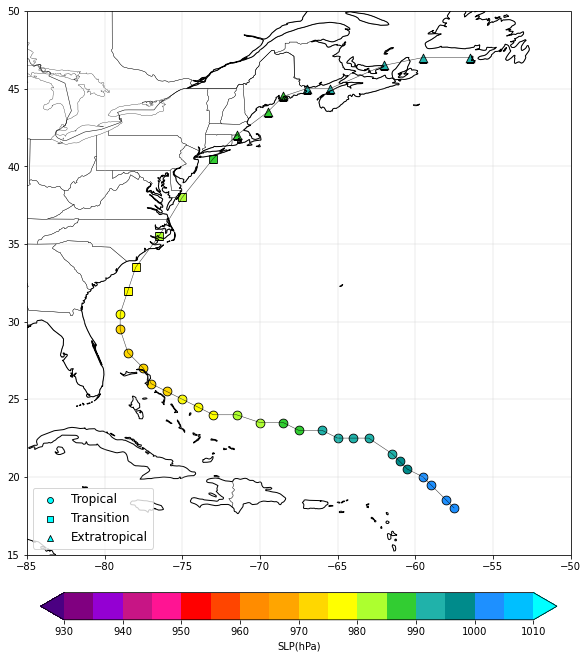

In [30]:
# Plot Cyclone Track
def Plot_Cyclone_Track(Storm_Code, DF, Bounds, Colours, Loc):
    DF_Storm = DF[DF['Code'] == Storm_Code]
    Lon = numpy.array(DF_Storm['Lon'])
    Lat = numpy.array(DF_Storm['Lat'])
    Plot_Colour = list(DF_Storm['Colour'])
    Plot_Shape = list(DF_Storm['Shape'])
#
# Plotting
    Fig = pyplot.figure(figsize=(10,10))
    Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    Axis.coastlines()
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    Axis.plot(Lon-360, Lat, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Lon)):
        pyplot.scatter(Lon[k], Lat[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.8, edgecolors='black', s=78)
#
# Formatting
    x_Min = (int(round(numpy.min(Lon) / 5)) - 1) * 5 - 360
    x_Max = (int(round(numpy.max(Lon) / 5)) + 1) * 5 - 360
    y_Min = (int(round(numpy.min(Lat) / 5)) - 1) * 5
    y_Max = (int(round(numpy.max(Lat) / 5)) + 1) * 5
    x_Axis = numpy.arange(x_Min,x_Max+5,5)
    y_Axis = numpy.arange(y_Min,y_Max+5,5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='silver', linestyle='-')
    Gridline.xlocator = mticker.FixedLocator(x_Axis)
    Gridline.ylocator = mticker.FixedLocator(y_Axis)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.025, -0.12, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, label='SLP(hPa)', shrink=0.7)
    SLP_Legend(Loc)
Plot_Cyclone_Track(Storm_List[0], DF, SLP_Bounds, SLP_Colours, 3)   

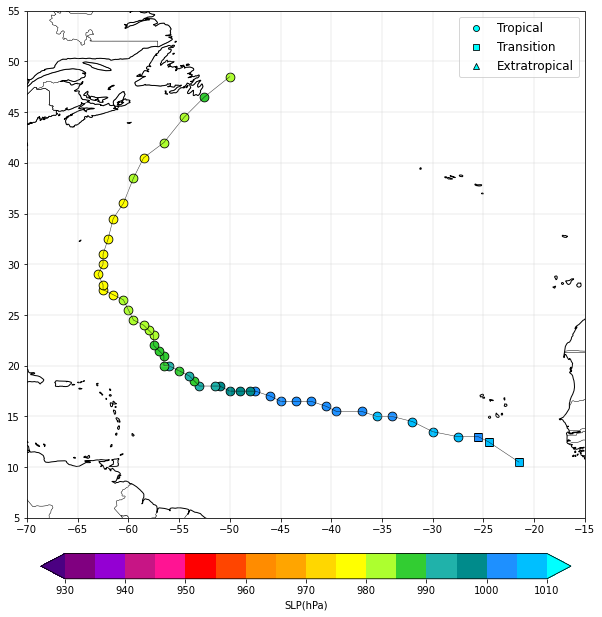

In [31]:
Plot_Cyclone_Track(Storm_List[1], DF, SLP_Bounds, SLP_Colours, 1)

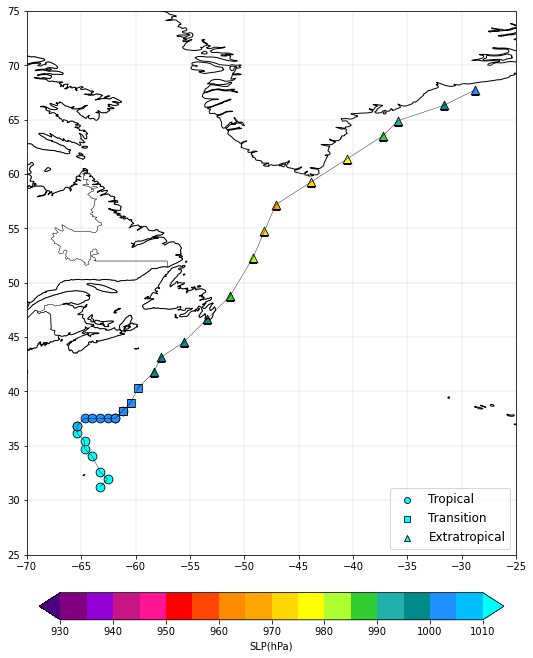

In [32]:
Plot_Cyclone_Track(Storm_List[3], DF, SLP_Bounds, SLP_Colours, 4)

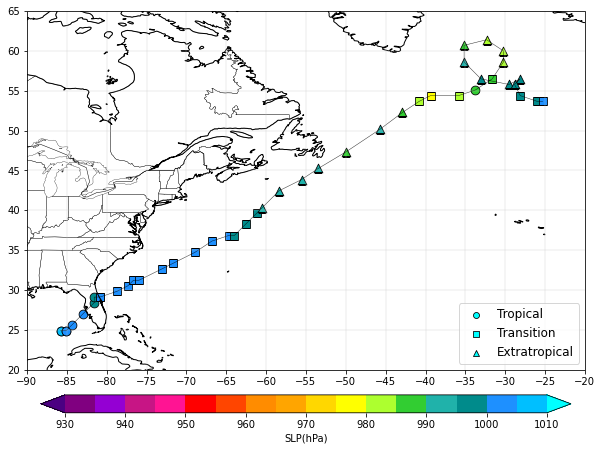

In [33]:
Plot_Cyclone_Track(Storm_List[5], DF, SLP_Bounds, SLP_Colours, 4)

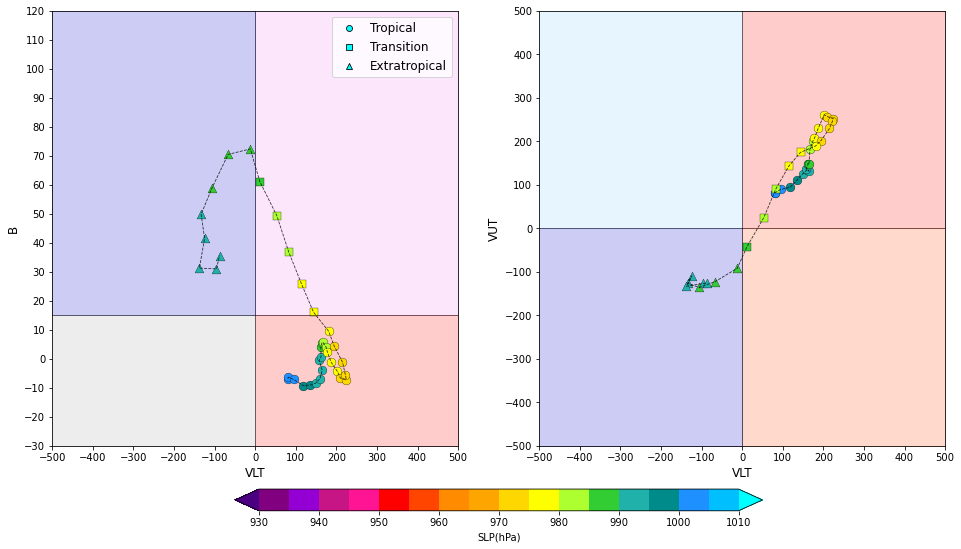

In [34]:
# Plot Cyclone Phase Diagram
def Plot_Cyclone_Phase(Storm_Code, DF, Bounds, Colours, Loc):
    DF_Storm = DF[DF['Code'] == Storm_Code]
    VLT = numpy.array(DF_Storm['VLT'])[1:]
    VUT = numpy.array(DF_Storm['VUT'])[1:]
    B = numpy.array(DF_Storm['B'])[1:]
    Plot_Colour = list(DF_Storm['Colour'])[1:]
    Plot_Shape = list(DF_Storm['Shape'])[1:]
#
# Plotting VUT VLT
    Fig = pyplot.figure(figsize=(16,8))
    Axis = Fig.add_subplot(1,2,1)
    x_Axis = numpy.arange(-500,600,100)
    y_Axis = numpy.arange(-30,130,10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-30,120)
    pyplot.fill_between([0,500], 15, 120, color='violet', alpha=0.2)
    pyplot.fill_between([-500,0], 15, 120, color='mediumblue', alpha=0.2)
    pyplot.fill_between([0,500], -30, 15, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], -30, 15, color='darkgrey', alpha=0.2)
    pyplot.plot([-500,500], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-30,120], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    Axis.plot(VLT, B, c='black', linestyle='--', linewidth=0.8, alpha=0.8)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], B[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.3, edgecolors='black', s=78)
    SLP_Legend(Loc)
#
# Plotting VUT VLT
    Axis = Fig.add_subplot(1,2,2)
    x_Axis = numpy.arange(-500,600,100)
    y_Axis = numpy.arange(-500,600,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-500,500)
    pyplot.fill_between([0,500], 500, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], 500, color='lightskyblue', alpha=0.2)
    pyplot.fill_between([0,500], -500, color='orangered', alpha=0.2)
    pyplot.fill_between([-500,0], -500, color='mediumblue', alpha=0.2)
    pyplot.plot([-500,500], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-500,500], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    Axis.plot(VLT, VUT, c='black', linestyle='--', linewidth=0.8, alpha=0.8)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], VUT[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.3, edgecolors='black', s=78)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.75, -0.15, 1.3, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, label='SLP(hPa)', shrink=0.7)
Plot_Cyclone_Phase(Storm_List[0], DF, SLP_Bounds, SLP_Colours, 1)

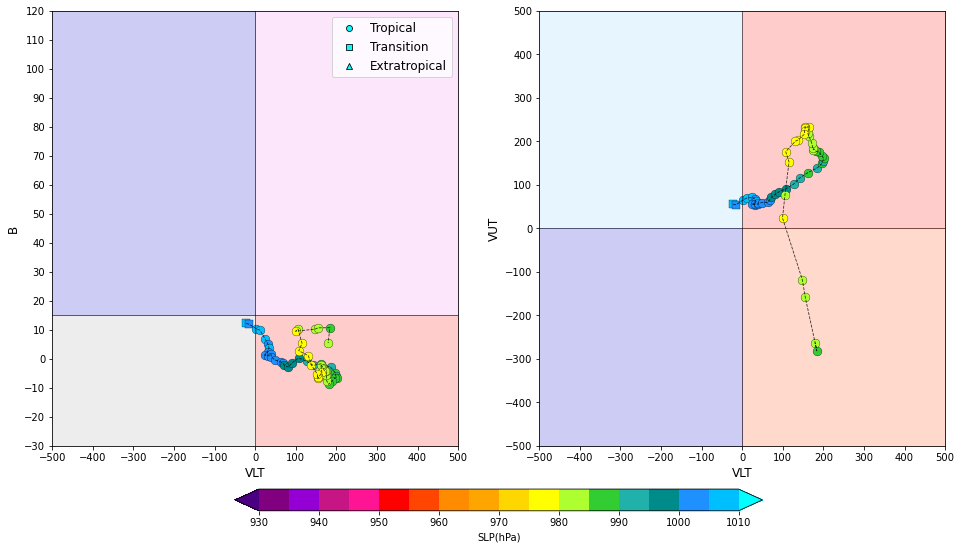

In [35]:
Plot_Cyclone_Phase(Storm_List[1], DF, SLP_Bounds, SLP_Colours, 1)

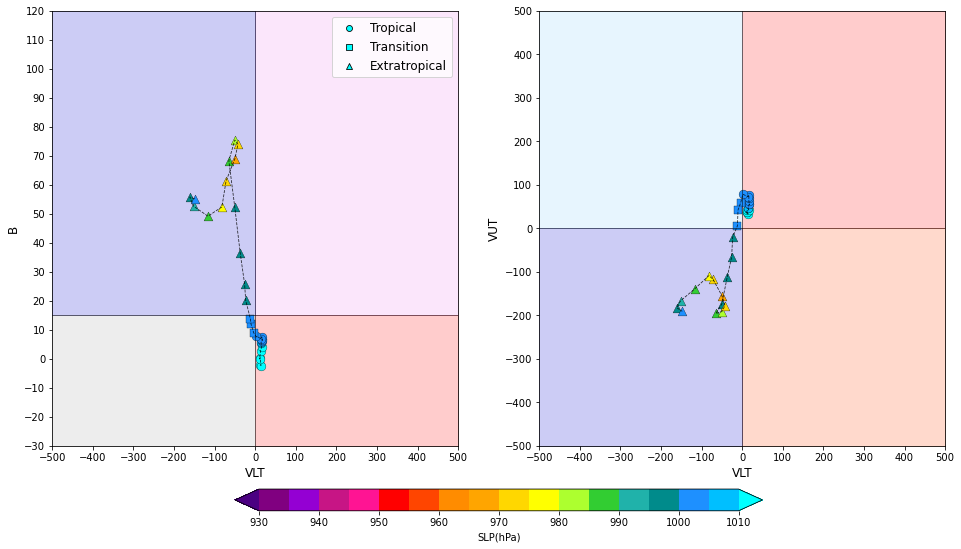

In [36]:
Plot_Cyclone_Phase(Storm_List[3], DF, SLP_Bounds, SLP_Colours, 1)

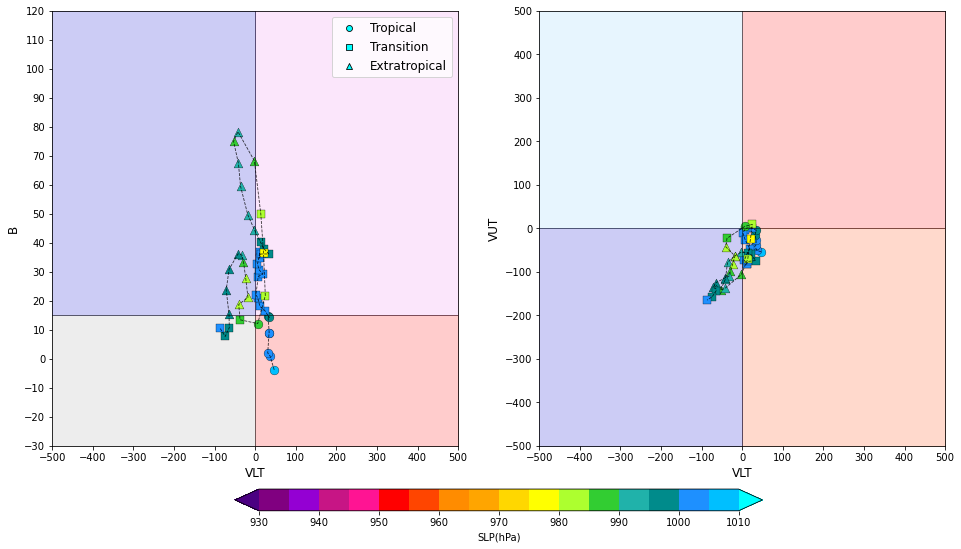

In [37]:
Plot_Cyclone_Phase(Storm_List[5], DF, SLP_Bounds, SLP_Colours, 1)

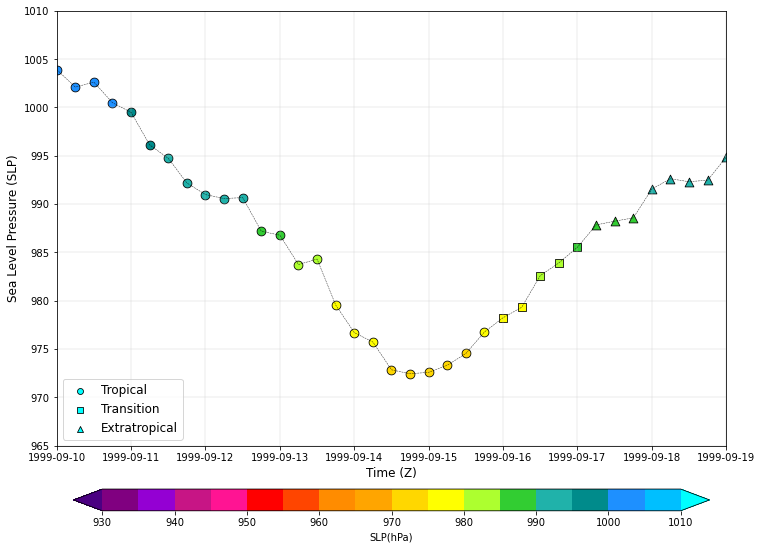

In [39]:
# Plot Cyclone SLP
def Plot_Cyclone_SLP(Storm_Code, DF, Bounds, Colours, Loc):
    DF_Storm = DF[DF['Code'] == Storm_Code]
    Time = list(DF_Storm['Time(Z)'])
    SLP = numpy.array(DF_Storm['SLP(hPa)'])
    Plot_Colour = list(DF_Storm['Colour'])
    Plot_Shape = list(DF_Storm['Shape'])
#
# Plotting
    Fig = pyplot.figure(figsize=(12,8))
    Axis = Fig.add_subplot(1,1,1)
    Axis.plot(Time, SLP, c='black', linestyle='--', linewidth=0.5, alpha=0.8)
    for k in range(len(Time)):
        Axis.scatter(Time[k], SLP[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.8, edgecolors='black', s=78)
#
# Formatting
    pyplot.xlabel('Time (Z)', fontsize=12)
    pyplot.ylabel('Sea Level Pressure (SLP)', fontsize=12)
    x_Min = Time[0]
    x_Max = Time[len(Time)-1]
    y_Min = (int(round(numpy.min(SLP) / 5)) - 1) * 5
    y_Max = (int(round(numpy.max(SLP) / 5)) + 1) * 5
    y_Axis = numpy.arange(y_Min,y_Max+5,5)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.025, -0.15, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, label='SLP(hPa)', shrink=0.7)
    SLP_Legend(Loc)
Plot_Cyclone_SLP(Storm_List[0], DF, SLP_Bounds, SLP_Colours, 3)

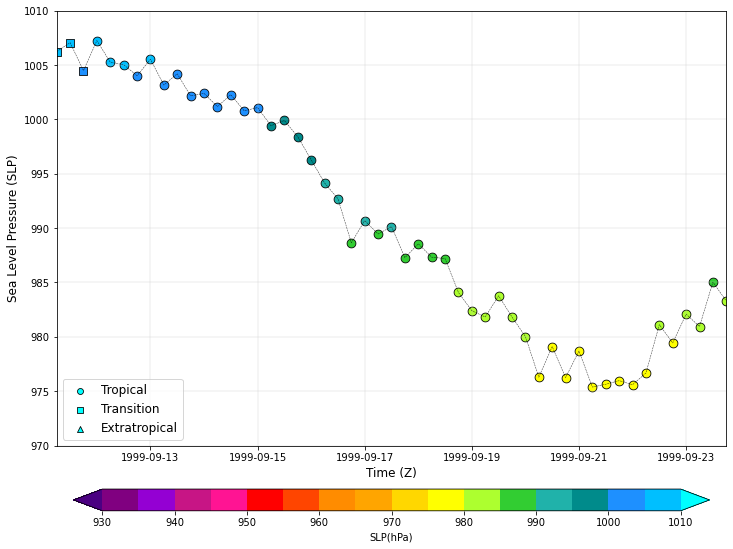

In [40]:
Plot_Cyclone_SLP(Storm_List[1], DF, SLP_Bounds, SLP_Colours, 3)

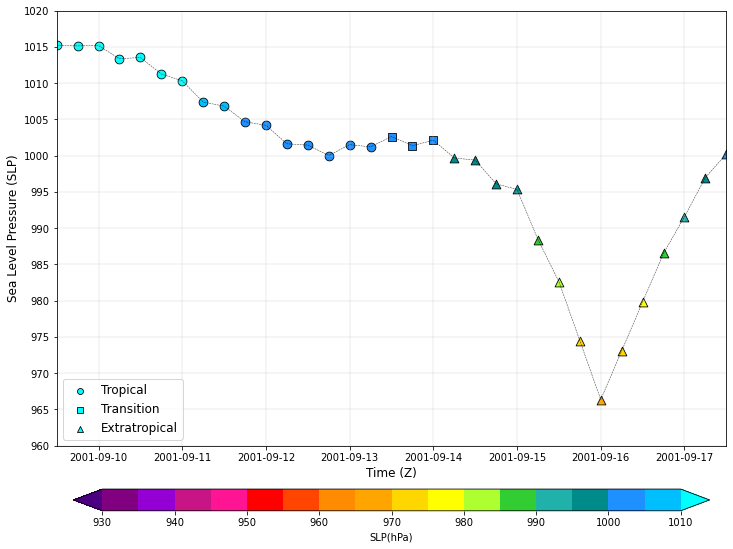

In [41]:
Plot_Cyclone_SLP(Storm_List[3], DF, SLP_Bounds, SLP_Colours, 3)

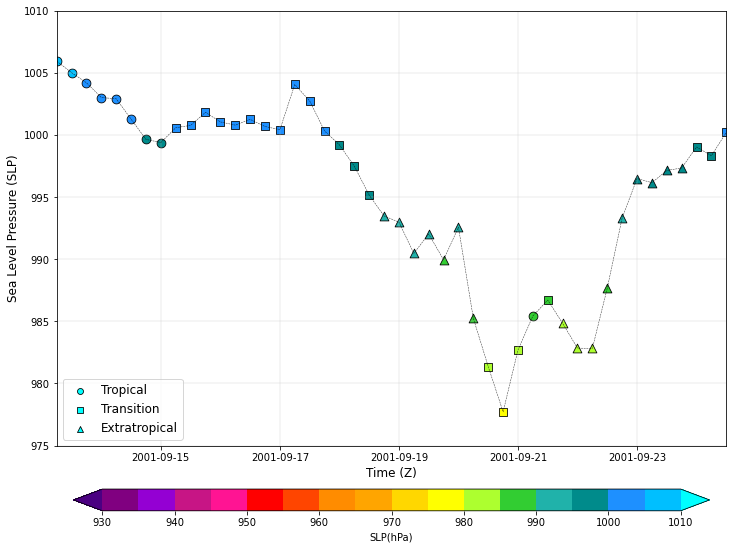

In [42]:
Plot_Cyclone_SLP(Storm_List[5], DF, SLP_Bounds, SLP_Colours, 3)

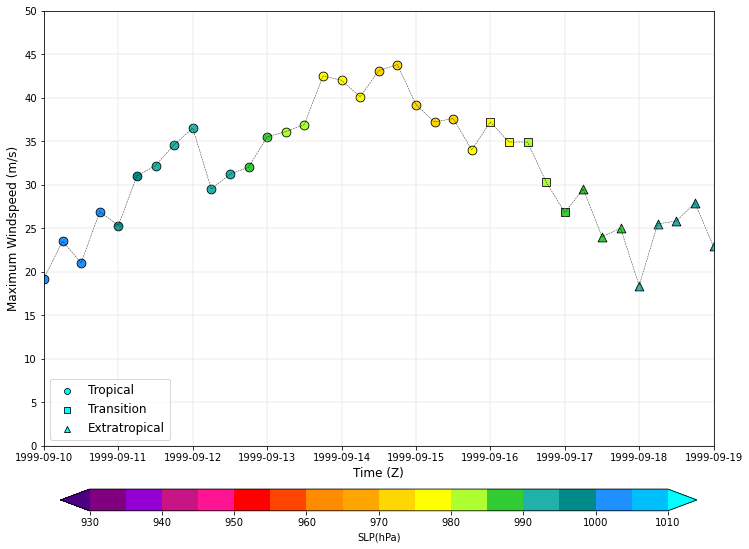

In [44]:
# Plot Cyclone Windspeed
def Plot_Cyclone_Winds(Storm_Code, DF, Bounds, Colours, Loc):
    DF_Storm = DF[DF['Code'] == Storm_Code]
    Time = list(DF_Storm['Time(Z)'])
    Winds = numpy.array(DF_Storm['Winds(m/s)'])
    Plot_Colour = list(DF_Storm['Colour'])
    Plot_Shape = list(DF_Storm['Shape'])
#
# Plotting
    Fig = pyplot.figure(figsize=(12,8))
    Axis = Fig.add_subplot(1,1,1)
    Axis.plot(Time, Winds, c='black', linestyle='--', linewidth=0.5, alpha=0.8)
    for k in range(len(Time)):
        Axis.scatter(Time[k], Winds[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.8, edgecolors='black', s=78)
#
# Formatting
    pyplot.xlabel('Time (Z)', fontsize=12)
    pyplot.ylabel('Maximum Windspeed (m/s)', fontsize=12)
    x_Min = Time[0]
    x_Max = Time[len(Time)-1]
    y_Min = 0
    y_Max = (int(round(numpy.max(Winds) / 5)) + 1) * 5
    y_Axis = numpy.arange(y_Min,y_Max+5,5)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(0,y_Max)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.025, -0.15, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, label='SLP(hPa)', shrink=0.7)
    SLP_Legend(Loc)
Plot_Cyclone_Winds(Storm_List[0], DF, SLP_Bounds, SLP_Colours, 3)

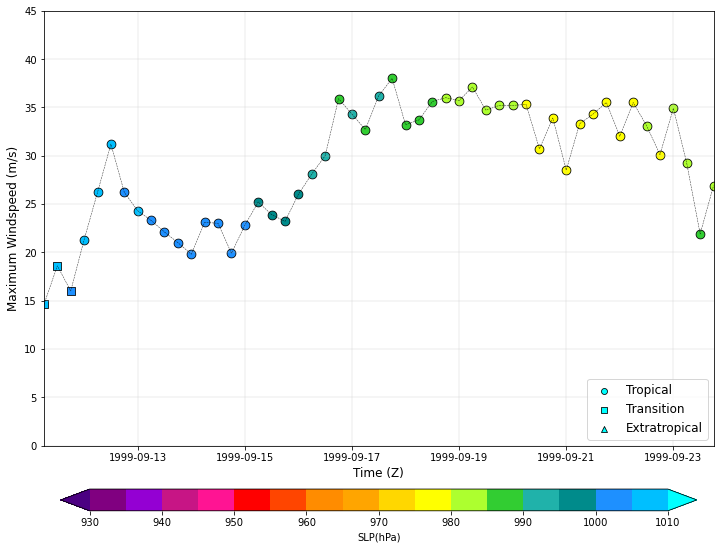

In [45]:
Plot_Cyclone_Winds(Storm_List[1], DF, SLP_Bounds, SLP_Colours, 2)

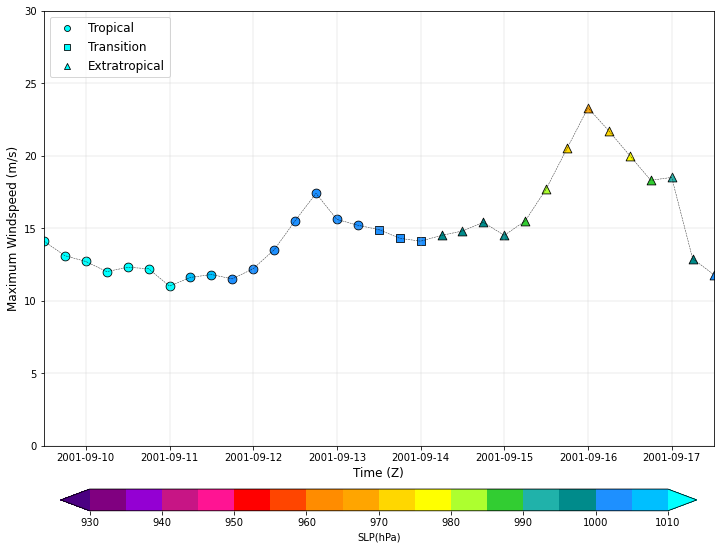

In [48]:
Plot_Cyclone_Winds(Storm_List[3], DF, SLP_Bounds, SLP_Colours, 2)

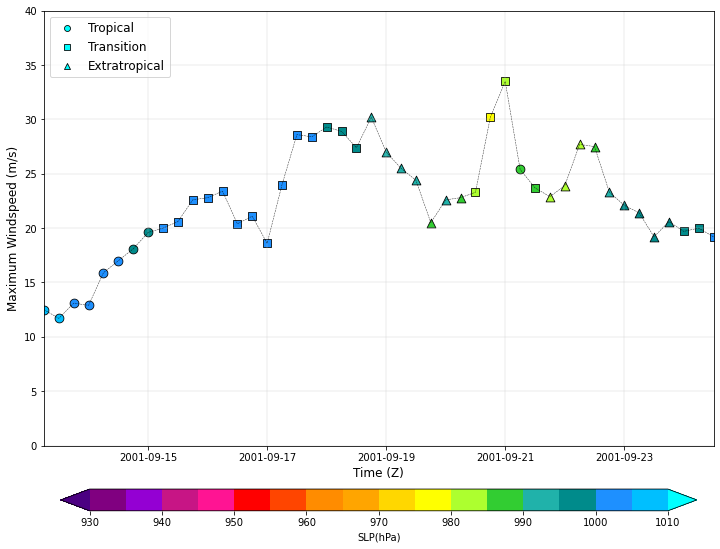

In [49]:
Plot_Cyclone_Winds(Storm_List[5], DF, SLP_Bounds, SLP_Colours, 2)